# CUMUL

This notebook is an attempt to recreate teh CUMUL solution for WFA proposed by XXXX in 2017?

The code was not provided, so this is an approximation based on the description in the paper.

In [1]:
import os
import numpy as np
from scapy.all import *
from tqdm import tqdm
import pandas as pd
from functions import label_others

In [2]:
FEATURES_TOR_PATH = "data/AWS_61k_TOR/tor/20_sec_features-2023_04_16__10_17_44-cumul_tor.npy"
FEATURES_TCP_PATH = "data/AWS_61k_TOR/tor/20_sec_features-2023_04_16__10_17_44-cumul_tcp.npy"
LABELS_PATH = "data/AWS_61k_TOR/tor/20_sec_labels-2023_04_16__10_17_44-df_tor.npy"
SITES_PATH = "VPN_client_scripts/urls/top_100_v2.csv"

SEED = 42
MIN_SAMPLES = 150

TOR = True

In [3]:
with open(FEATURES_TCP_PATH, 'rb') as f:
    features_tcp = np.load(f)

with open(FEATURES_TOR_PATH, 'rb') as f:
    features_tor = np.load(f)

with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)

sites_df = pd.read_csv(SITES_PATH, names=["ranking", "site", "tor_compatible"])
if TOR:
    sites_df = sites_df[sites_df["tor_compatible"] == 1]
sites = list(sites_df.site)

# Add 'Others' label

In [4]:
labels = label_others(labels, sites, MIN_SAMPLES)

# Visualiser  

In [5]:
import matplotlib.colors as mcolors

features_dict = {
    "tcp": features_tcp,
    "tor": features_tor,
}


def plot_cumul(features, n, y_label):

    features_cumul = features_dict[features][:n]
    # Assuming you already have vpn_features_cumul_np and vpn_labels_cumul_np defined

    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)

    # Create a label to integer mapping
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    
    plt.figure(figsize=(7, 5))

    # Create a colormap
    cmap = plt.get_cmap("tab10", num_labels)


    # Normalize the integer labels to the range of the colormap
    norm = mcolors.Normalize(vmin=0, vmax=num_labels - 1)

    for x in range(features_cumul.shape[0]):
        label_integer = label_mapping[labels[x]]
        color = cmap(norm(label_integer))
        plt.plot(features_cumul[x], color=color)

    plt.xlabel("Sequence number")
    plt.ylabel(y_label)
    plt.show()

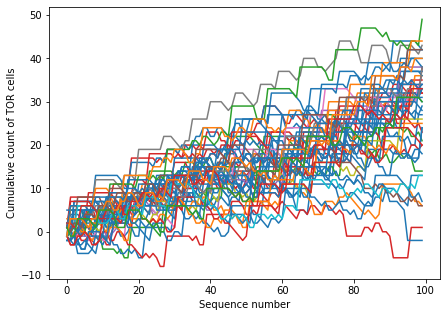

In [6]:
plot_cumul('tor', 50, 'Cumulative count of TOR cells')

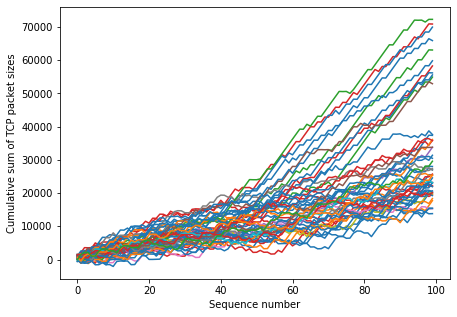

In [7]:
plot_cumul('tcp', 50, 'Cumulative sum of TCP packet sizes')

# ML Models

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [11]:
features_dict['tcp'].shape

(27862, 100)

# TCP packets

In [12]:
def pre_process_data(pet, labels=labels, test_size=0.2):

    features = features_dict[pet]

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)

    # Standardize the features - MinMax Scaler used, as described in the paper.
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

## K-NN on TCP data

In [13]:
x_train, x_test, y_train, y_test = pre_process_data('tcp')

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def optimise_knn(x_train, x_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(x_train, y_train)
    y_pred_knn = knn.predict(x_test)



    # Define the parameter grid for the grid search
    param_grid = {
        'n_neighbors': list(range(3, 11))  # k values between 3 and 10
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

    # Perform the grid search
    grid_search.fit(x_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best parameters:', best_params)

    # Train the kNN classifier with the best parameters on the entire training set
    best_knn = grid_search.best_estimator_
    best_knn.fit(x_train, y_train)

    # Test the best kNN model
    y_pred = best_knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



In [14]:
optimise_knn(x_train, x_test, y_train, y_test)

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over 

Best parameters: {'n_neighbors': 10}


/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3768167952628746
[[2098    3    0 ...    0    0    1]
 [  51    0    0 ...    0    0    0]
 [  55    0    0 ...    0    0    0]
 ...
 [  47    0    0 ...    0    0    0]
 [  47    0    0 ...    0    0    0]
 [  52    1    0 ...    0    0    0]]
                   precision    recall  f1-score   support

            Other       0.39      0.97      0.55      2159
        adobe.com       0.00      0.00      0.00        53
      alibaba.com       0.00      0.00      0.00        56
   aliexpress.com       0.00      0.00      0.00        57
       amazon.com       0.00      0.00      0.00        72
         avito.ru       0.00      0.00      0.00        48
          bbc.com       0.00      0.00      0.00        54
         bing.com       0.00      0.00      0.00        55
      booking.com       0.00      0.00      0.00        55
        canva.com       0.25      0.02      0.04        47
        deepl.com       0.00      0.00      0.00        44
      discord.com       0.00      

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM on TCP

In [14]:
from sklearn.svm import SVC


def optimise_svm(x_train, x_test, y_train, y_test):
    # Create an SVM
    svm = SVC()

    # Define the parameter grid for the grid search
    param_grid = {
        'C': np.logspace(-15, 3, num=19, base=2),  # C between 2^-15 and 2^3
        'gamma': np.logspace(-3, 3, num=7, base=2),  # gamma between 2^-3 and 2^3
        'kernel': ['rbf']
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

    # Perform the grid search
    grid_search.fit(x_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best parameters:', best_params)

    # Train the SVM with the best parameters on the entire training set
    best_svm = grid_search.best_estimator_
    best_svm.fit(x_train, y_train)

    # Test the best SVM model
    y_pred = best_svm.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


In [15]:
optimise_svm(x_train, x_test, y_train, y_test)

Best parameters: {'C': 3.0517578125e-05, 'gamma': 0.125, 'kernel': 'rbf'}
Accuracy: 0.38740355284406963
[[2159    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]
 [  56    0    0 ...    0    0    0]
 ...
 [  48    0    0 ...    0    0    0]
 [  47    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]]
                   precision    recall  f1-score   support

            Other       0.39      1.00      0.56      2159
        adobe.com       0.00      0.00      0.00        53
      alibaba.com       0.00      0.00      0.00        56
   aliexpress.com       0.00      0.00      0.00        57
       amazon.com       0.00      0.00      0.00        72
         avito.ru       0.00      0.00      0.00        48
          bbc.com       0.00      0.00      0.00        54
         bing.com       0.00      0.00      0.00        55
      booking.com       0.00      0.00      0.00        55
        canva.com       0.00      0.00      0.00        47
        deepl.com 

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [18]:
# Train and evaluate the SVM model
svm = SVC(kernel='rbf', C=3.0517578125e-05, gamma=0.125)
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

print("SVM Model:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Model:
[[2159    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]
 [  56    0    0 ...    0    0    0]
 ...
 [  48    0    0 ...    0    0    0]
 [  47    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]]
                   precision    recall  f1-score   support

            Other       0.39      1.00      0.56      2159
        adobe.com       0.00      0.00      0.00        53
      alibaba.com       0.00      0.00      0.00        56
   aliexpress.com       0.00      0.00      0.00        57
       amazon.com       0.00      0.00      0.00        72
         avito.ru       0.00      0.00      0.00        48
          bbc.com       0.00      0.00      0.00        54
         bing.com       0.00      0.00      0.00        55
      booking.com       0.00      0.00      0.00        55
        canva.com       0.00      0.00      0.00        47
        deepl.com       0.00      0.00      0.00        44
      discord.com       0.00      0.00      0.00    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

# TOR Cells

In [16]:
if TOR:
    x_train, x_test, y_train, y_test = pre_process_data('tor')

## KNN on TOR packets

In [17]:
if TOR:
    optimise_knn(x_train, x_test, y_train, y_test)

NameError: name 'optimise_knn' is not defined

## SVM on TOR

In [18]:
if TOR:
    optimise_svm(x_train[:3000], x_test, y_train[:3000], y_test)

Best parameters: {'C': 3.0517578125e-05, 'gamma': 0.125, 'kernel': 'rbf'}
Accuracy: 0.38740355284406963
[[2159    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]
 [  56    0    0 ...    0    0    0]
 ...
 [  48    0    0 ...    0    0    0]
 [  47    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]]
                   precision    recall  f1-score   support

            Other       0.39      1.00      0.56      2159
        adobe.com       0.00      0.00      0.00        53
      alibaba.com       0.00      0.00      0.00        56
   aliexpress.com       0.00      0.00      0.00        57
       amazon.com       0.00      0.00      0.00        72
         avito.ru       0.00      0.00      0.00        48
          bbc.com       0.00      0.00      0.00        54
         bing.com       0.00      0.00      0.00        55
      booking.com       0.00      0.00      0.00        55
        canva.com       0.00      0.00      0.00        47
        deepl.com 

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [24]:
# Train and evaluate the SVM model
svm = SVC(kernel='rbf', C=3.0517578125e-05, gamma=0.125)
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

print("SVM Model:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Model:
[[2159    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]
 [  56    0    0 ...    0    0    0]
 ...
 [  48    0    0 ...    0    0    0]
 [  47    0    0 ...    0    0    0]
 [  53    0    0 ...    0    0    0]]
                   precision    recall  f1-score   support

            Other       0.39      1.00      0.56      2159
        adobe.com       0.00      0.00      0.00        53
      alibaba.com       0.00      0.00      0.00        56
   aliexpress.com       0.00      0.00      0.00        57
       amazon.com       0.00      0.00      0.00        72
         avito.ru       0.00      0.00      0.00        48
          bbc.com       0.00      0.00      0.00        54
         bing.com       0.00      0.00      0.00        55
      booking.com       0.00      0.00      0.00        55
        canva.com       0.00      0.00      0.00        47
        deepl.com       0.00      0.00      0.00        44
      discord.com       0.00      0.00      0.00    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

## SVM with C and Gamma value taken form original paper
MinMax Scaler used, as described in the paper.

In this parameter grid, you have:

19 values for the 'C' parameter (np.logspace(-15, 3, num=19, base=2) creates 19 values).
7 values for the 'gamma' parameter (np.logspace(-3, 3, num=7, base=2) creates 7 values).
1 value for the 'kernel' parameter (['rbf']).
To find the total number of combinations, you can multiply the number of unique values for each parameter:

Total combinations = (number of 'C' values) * (number of 'gamma' values) * (number of 'kernel' values)

Total combinations = 19 * 7 * 1 = 133

So, there will be 133 different combinations in this parameter grid.